In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import sqlite3

c:\Users\chris\miniconda3\envs\LSTF_Linear\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


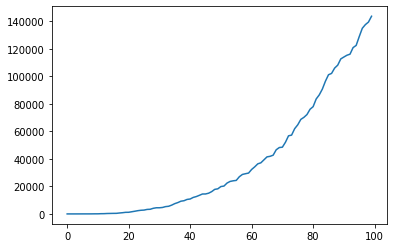

In [10]:
# it should struggle if the gaps keep getting bigger each time.

x = [1]
for i in range(99):
    x.append(x[i] + np.random.randint(0, i**2 + 1))

plt.plot(x)
plt.show()

Here I want to investigate how this method performs on models with and without alpha. My initial thoughts are that the model with alpha the predictions on average will be better so the scores are lower so the distances are smaller. 

How does this relate to distribution shift? We are interested in the time series nature of the data and how it deals with it so this still may be useful.

In [2]:
# This creates a TS, where the distribution changes at different points deppending on a provided list of distribution shifts.
def Create_TimeSeries(s, dist_shifts):
    n = s//len(dist_shifts)
    m = s%len(dist_shifts)

    final = np.array([])
    
    for i in range(len(dist_shifts)-1):
        Y = abs(np.random.normal(dist_shifts[i][0], dist_shifts[i][1], n))
        final = np.concatenate((final, Y))
    
    final = np.concatenate((final, abs(np.random.normal(dist_shifts[-1][0], dist_shifts[-1][1], n+m))))
    
    return final

In [31]:
def Generate_Data(seq_length):
    x = [np.random.randint(-10**3, 10**3)]
    for i in range(seq_length-100):
        x.append(x[i] + np.random.randint(0, i**2 + 1))

    for m in range(100):
        x.append(np.random.randint(0, m**4 + 1))
    return x

In [32]:
# Here we will just look at a simple random walk.

p = 0.5
pdist = [1-p, p]
steps = [-1, 1]

datapoints = 10
seq_length = 300

output_label_tuples = []


for _ in range(datapoints):
    T = Generate_Data(seq_length)
    
    input_data = T[:-1]
    labels_data = T[1:]

    output_label_tuples.append((input_data, labels_data))

In [33]:
train_Output = output_label_tuples

In [40]:
def Model(x):
    add = 0.00
    return x + (np.random.choice(steps, len(x), p=[0.5-add, 0.5+add]) * abs(np.random.normal(0, 10000, len(x))))

Would It not just be better to take the previous value as the thing -> this woudl make more sense but the whole of this technique is that it that should on any model. This is a good test for your models which you have been making as this is a sense where it is impossible to get any on the model.

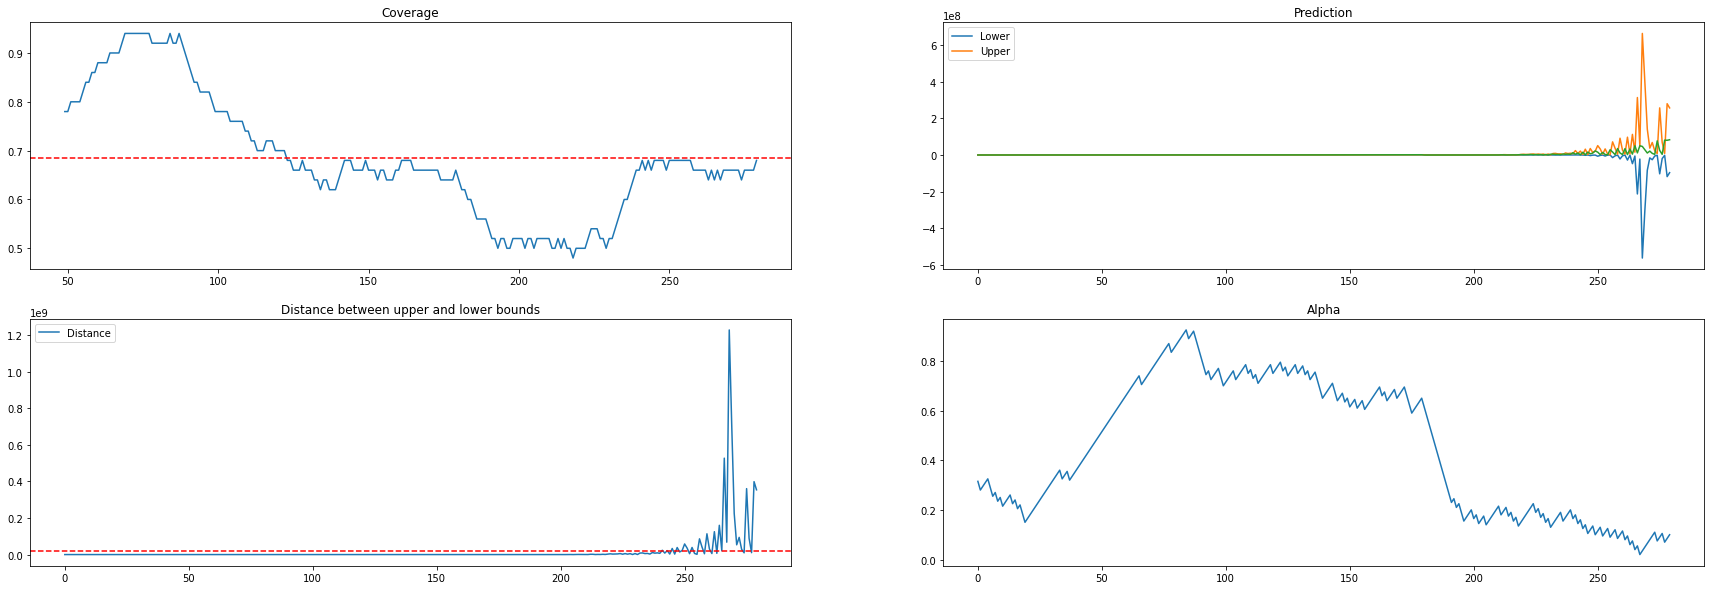

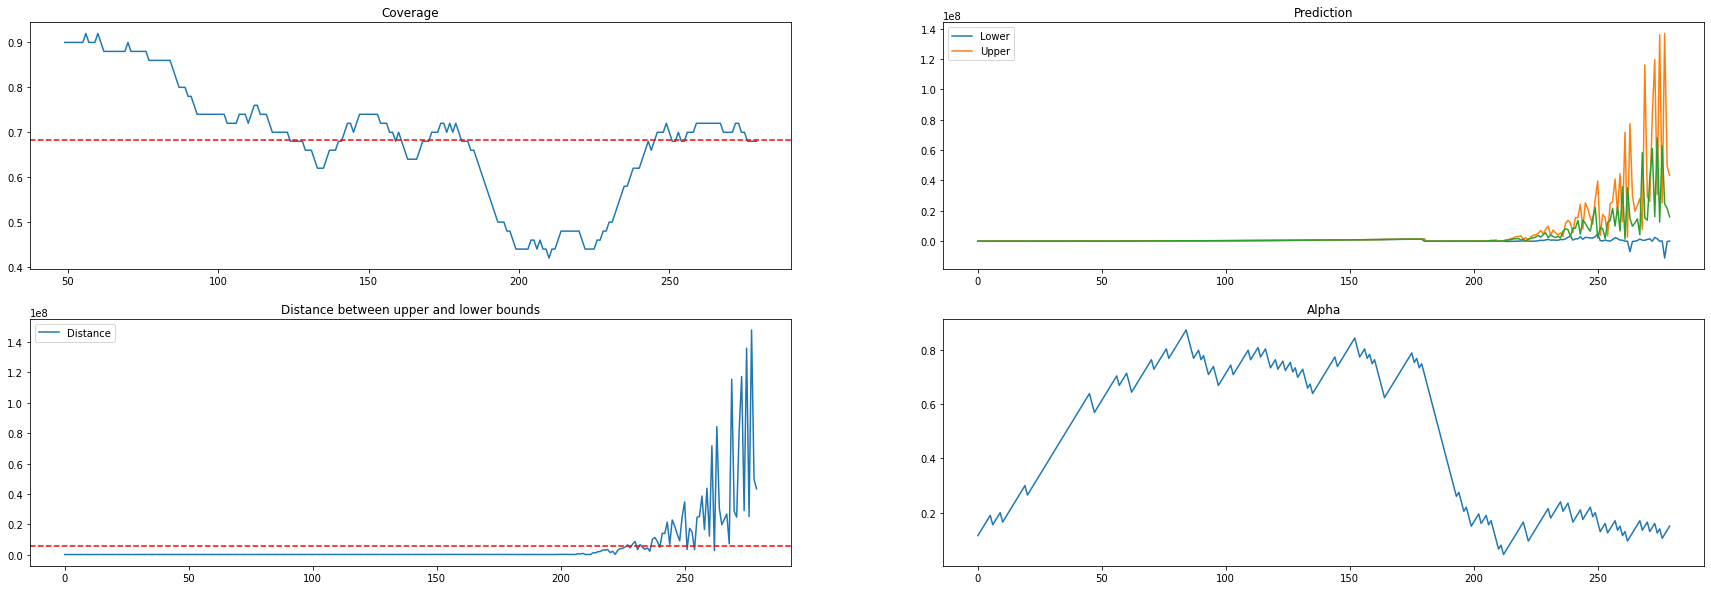

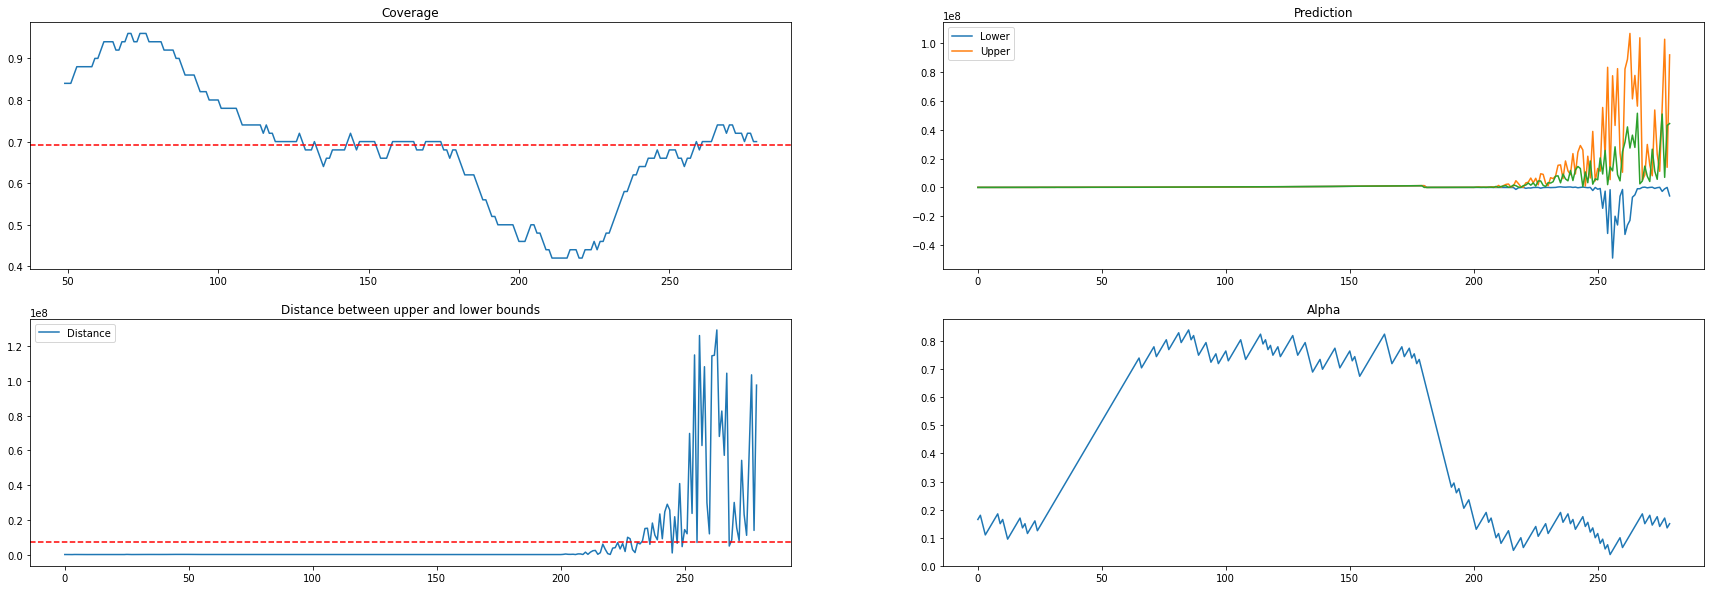

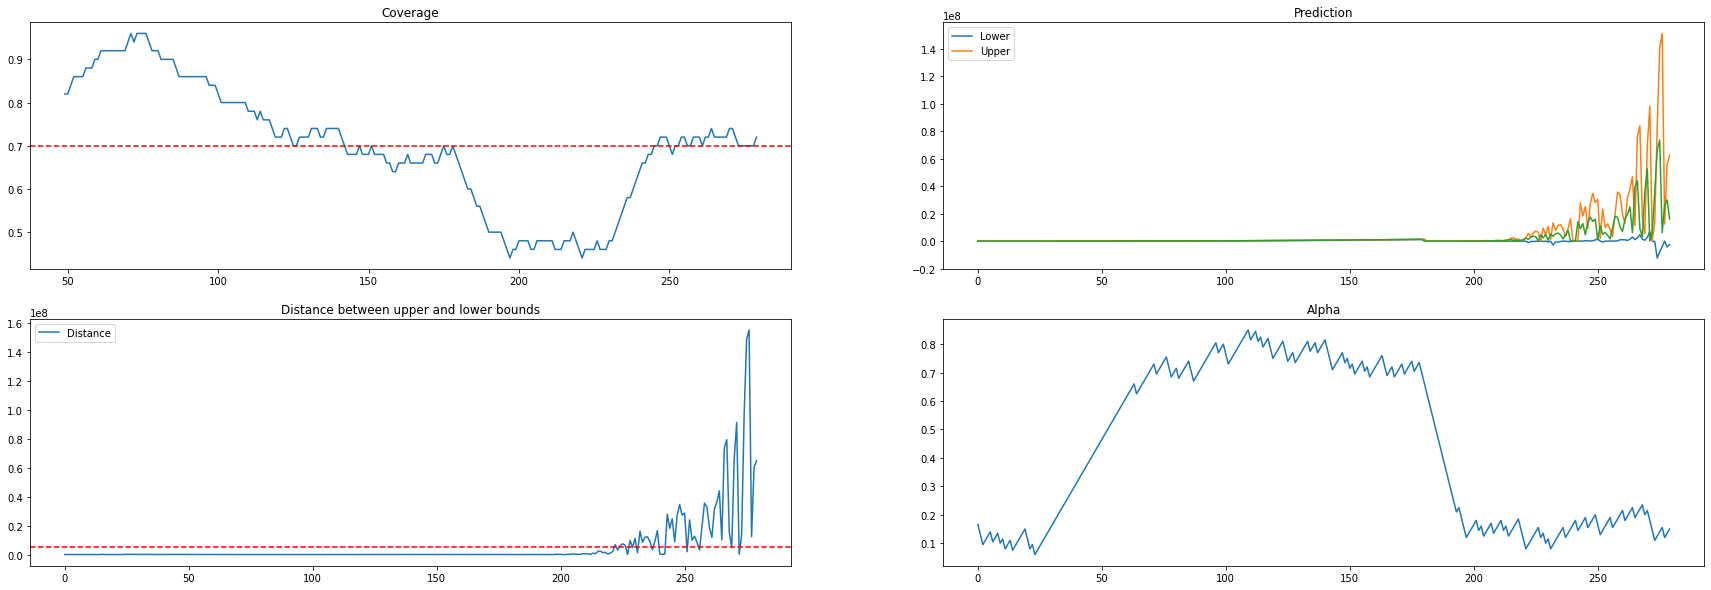

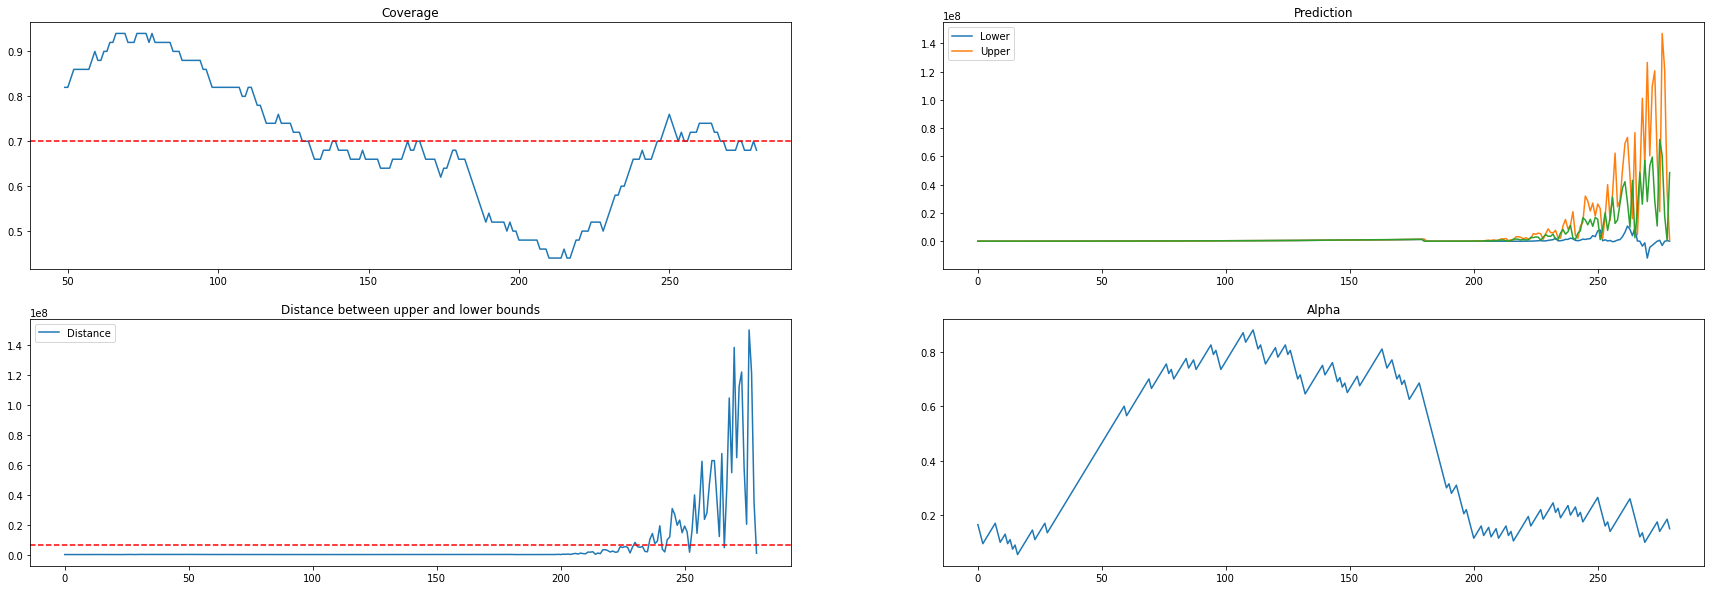

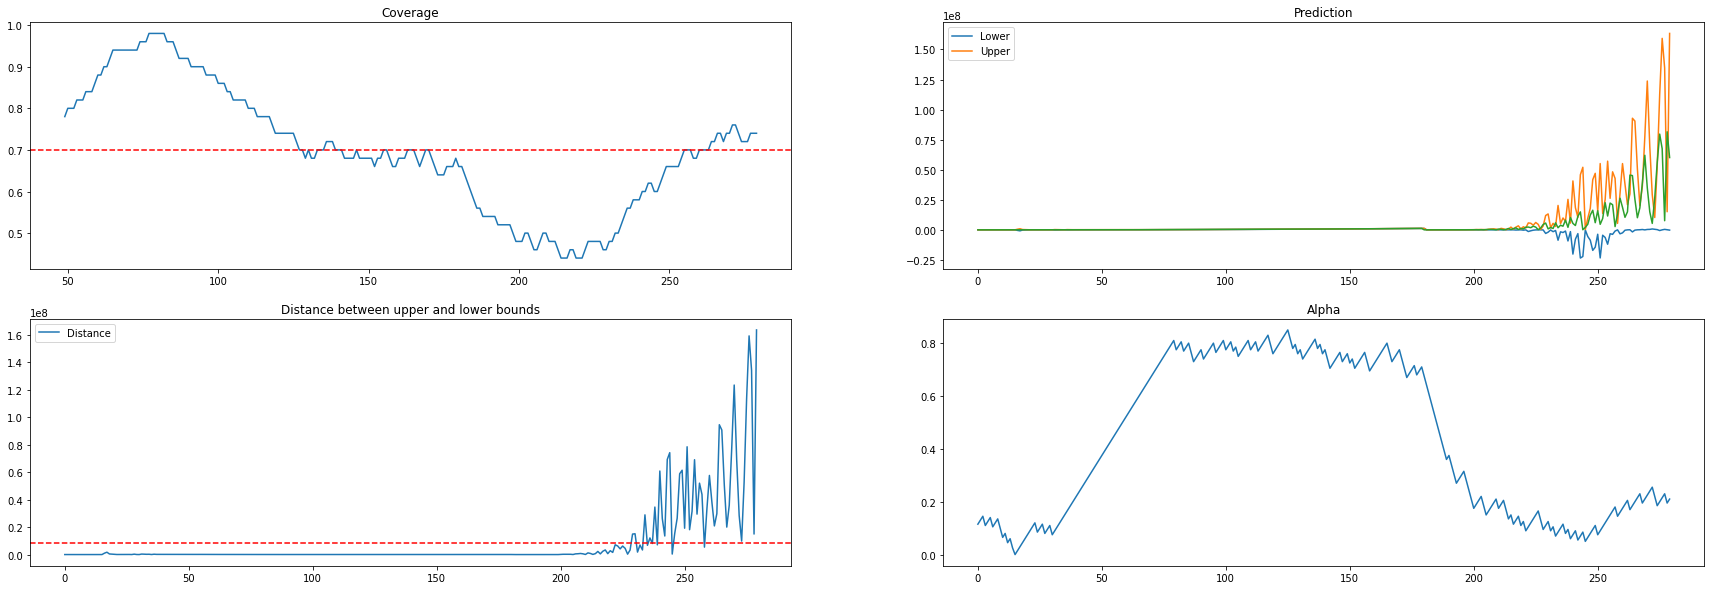

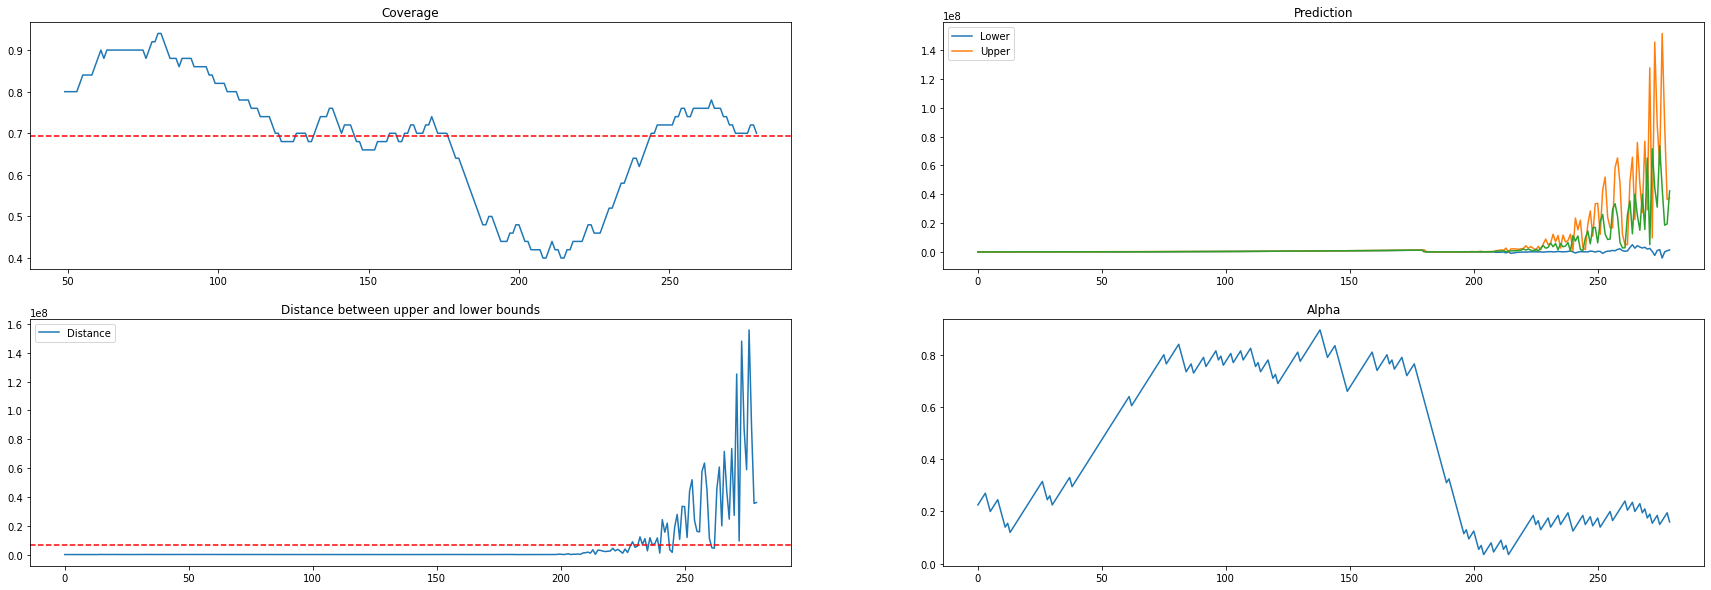

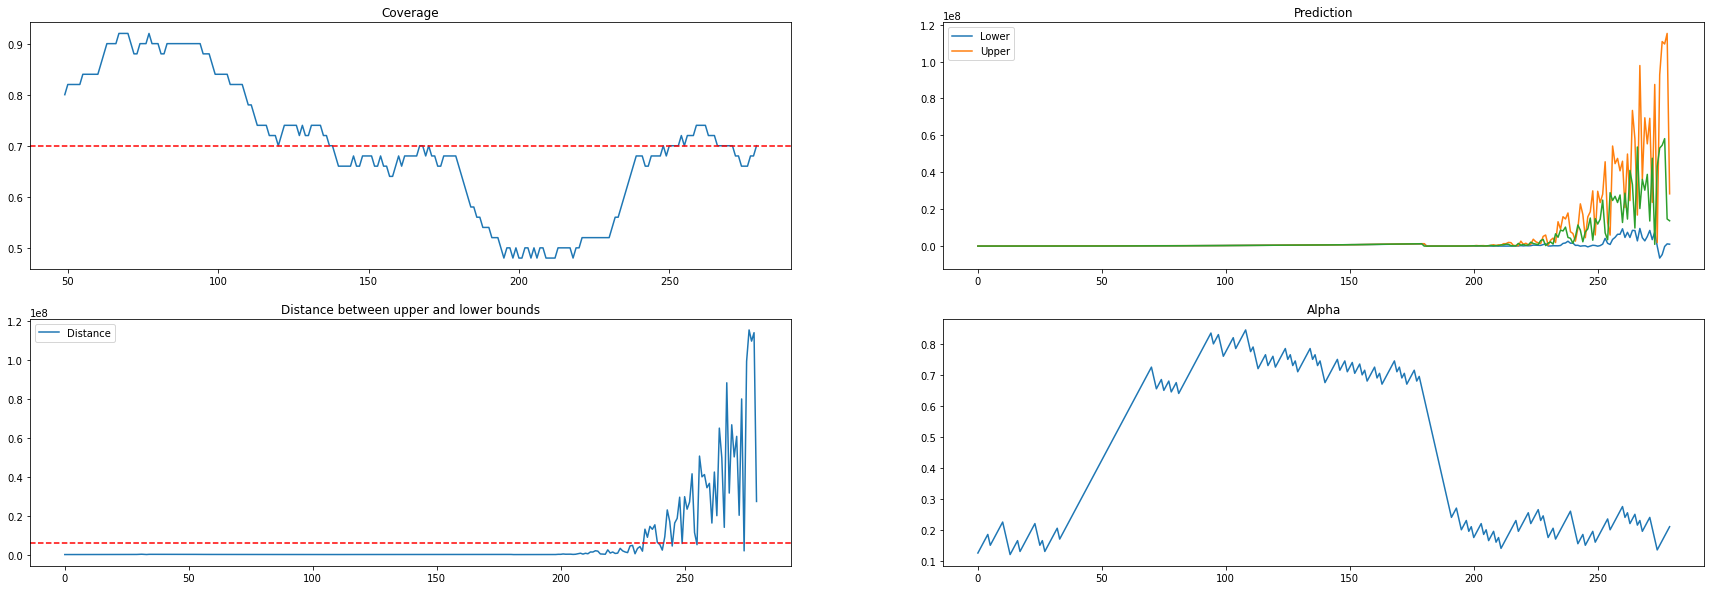

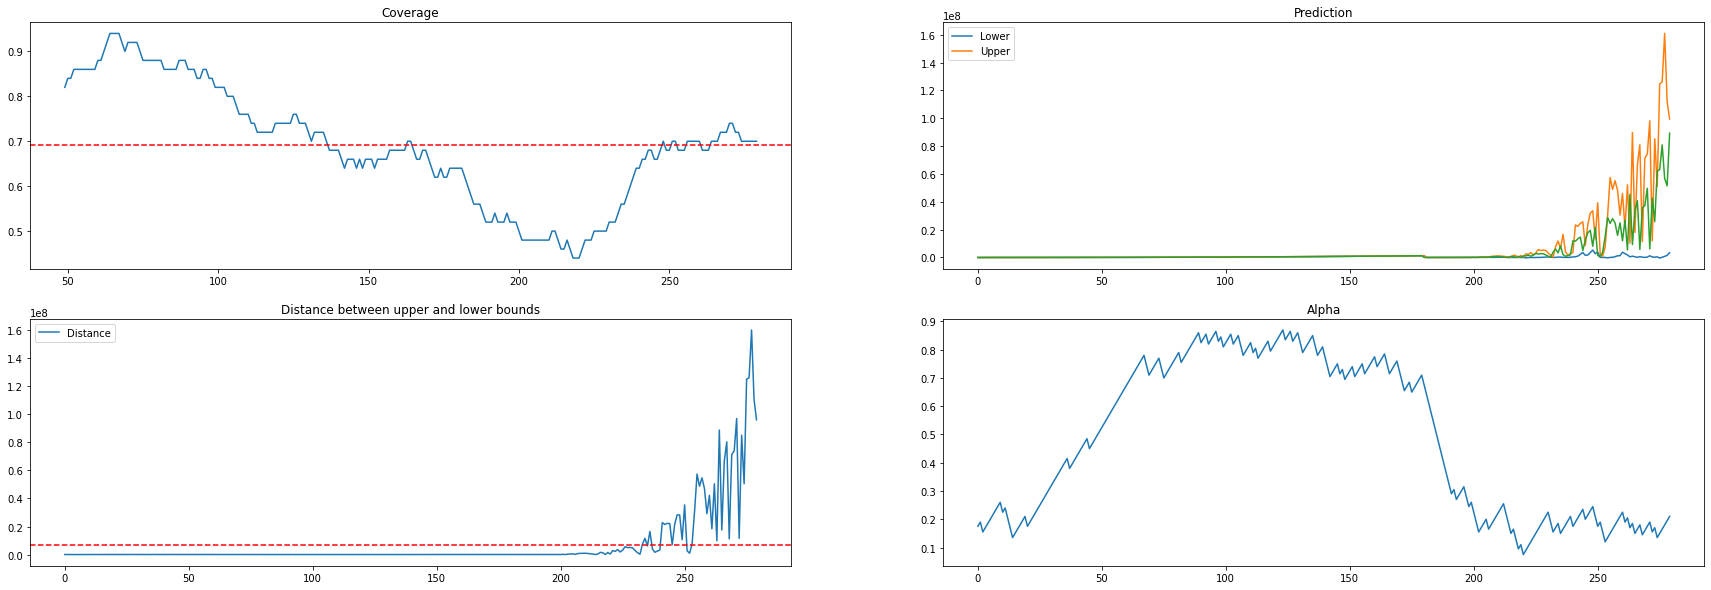

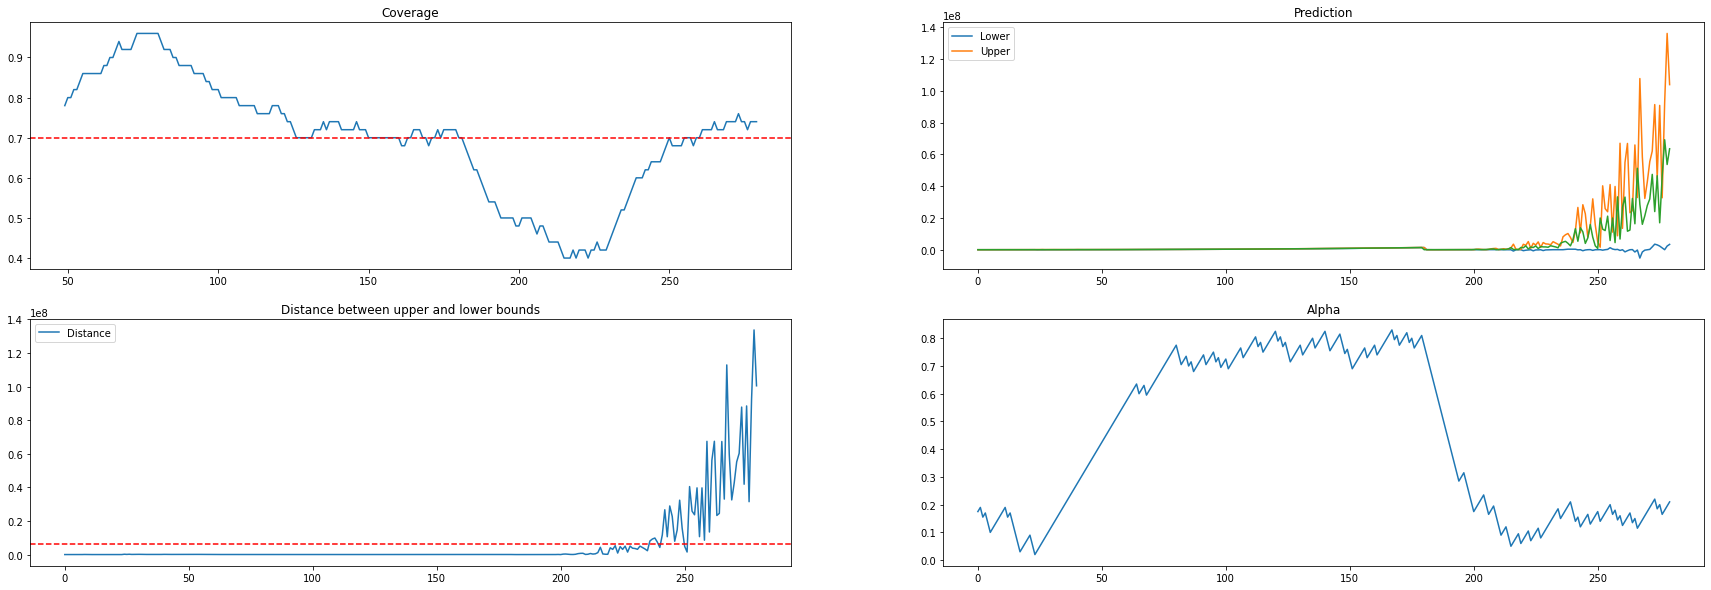

The average coverage is 0.6941818181818181
The average distance between the upper and lower predictions is 6341619.159351499


In [41]:

# This function returns the quantile
def Q_t(p, scores):
    return np.quantile(scores, p)

# This function predicts a range of Y_t at the alpha level. By using alpha_t.
def C_t(alpha_t, scores, sigma_t, t):
    positve_v = (sigma_t) + (abs(sigma_t) * Q_t(1-alpha_t, scores[:t]))
    negative_v = (sigma_t) - (abs(sigma_t) * Q_t(1-alpha_t, scores[:t]))
    return negative_v, positve_v

# This function returns 1 if the prediction lies in the interval, 0 otherwise.
def err_t(Y_t, C_t):
    if C_t[0] < Y_t < C_t[1]:
        return 0
    else:
        return 1
    

# We have 240 elememts we want a decent approximation of the quantile. So we will start at.
inital_window_size = 50
alpha = 0.3
orignal_alpha = alpha 
gamma = 0.05


total_coverage_list = []

for m, (x, y) in enumerate(train_Output):
    # Getting the prediction and the actual value.
    xpred = Model(x)
    # Calculating the scores at each time step
    All_scores = (abs(y - xpred))/abs(xpred)

    error_list = []
    Coverage_list = []
    alpha_list = []
    
    for i in range(20, len(All_scores)):
        Coverage_t = C_t(alpha, All_scores, xpred[i], i)
        Coverage_list.append(Coverage_t)
        error_t = err_t(y[i], Coverage_t)
        error_list.append(error_t)

        alpha = min(max(alpha + (gamma * (orignal_alpha - error_t)), 0), 1)
        alpha_list.append(alpha)

    
    coverage = 1 - pd.Series(error_list).rolling(50).mean().mean()
    total_coverage_list.append(coverage)
    
    if m<10:
        fig, axs = plt.subplots(2, 2, figsize=(30, 10))
        
        axs[0][0].plot(1 - pd.Series(error_list).rolling(50).mean())
        axs[0][0].axhline(coverage, color='r', linestyle='--')
        axs[0][0].set_title('Coverage')
        
        axs[0][1].plot([ele[0] for ele in Coverage_list], label='Lower')
        axs[0][1].plot([ele[1] for ele in Coverage_list], label='Upper')
        axs[0][1].plot(y[20:])
        axs[0][1].set_title('Prediction')
        axs[0][1].legend()

        axs[1][0].plot([ele[1]-ele[0] for ele in Coverage_list], label='Distance')
        axs[1][0].axhline(np.mean([ele[1]-ele[0] for ele in Coverage_list]), color='r', linestyle='--')
        axs[1][0].legend()
        axs[1][0].set_title('Distance between upper and lower bounds')

        axs[1][1].plot(alpha_list)
        axs[1][1].set_title('Alpha')


        plt.show()



print('The average coverage is', np.mean(total_coverage_list))

# Would be useful to know the average distance between the upper and lower predictions.
average_distance = np.mean([ele[1] - ele[0] for ele in Coverage_list])
print('The average distance between the upper and lower predictions is', average_distance)

Adaptive is completley hopeless as you would imagine.